STEP 1 —  IMPORTS + INSTALL DEPENDENCIES

In [ ]:
# ==========================================
# 1. SETUP & INSTALLATION
# ==========================================
# Install pyzbar (Python wrapper) and libzbar0 (System library required for decoding)
!pip install pyzbar
!apt-get install -y libzbar0

# Import necessary libraries
from google.colab import output
from google.colab.output import eval_js
from IPython.display import Javascript
import numpy as np
import cv2
from PIL import Image
import io, base64
from pyzbar.pyzbar import decode
import requests
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libzbar0 is already the newest version (0.23.92-4build2).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


STEP 2 — CAMERA FUNCTION

In [ ]:
# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def take_photo():
    """
    Captures a photo from the user's webcam using JavaScript.
    Context: Google Colab runs on a remote server, so we cannot access
    the local webcam directly via Python. We use a JS bridge instead.
    """
    js = """
    async function takePhoto() {
      // Create a video element to preview the webcam
      const video = document.createElement('video');
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);

      video.srcObject = stream;
      await video.play();

      // Wait for the video to be ready
      await new Promise(resolve => requestAnimationFrame(resolve));

      // Create a canvas to capture the frame
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      // Clean up the video stream
      stream.getVideoTracks()[0].stop();
      video.remove();

      // Return the image data as a Base64 string
      return canvas.toDataURL('image/png');
    }
    takePhoto();
    """
    # Execute the JavaScript
    data = eval_js(js)
    # Decode the Base64 string into an image format Python can use
    image_bytes = base64.b64decode(data.split(",")[1])
    img = Image.open(io.BytesIO(image_bytes))

    # Convert to a NumPy array for OpenCV processing
    return np.array(img)

STEP 3 — BARCODE PRODUCT API

In [ ]:
def get_product_info(barcode_number):
    """
    Queries the Open Food Facts API to retrieve product metadata.
    Args:
        barcode_number (str): The scanned EAN-13 or UPC barcode.
    Returns:
        dict: Product details (name, brand, nutrients) or None if not found.
    """
    # Construct the API URL
    url = f"https://world.openfoodfacts.org/api/v0/product/{barcode_number}.json"

    try:
        # Send HTTP GET request
        response = requests.get(url)
        data = response.json()

        # Check 'status' (1 means product found)
        if data["status"] == 1:
            product = data["product"]
            return {
                "name": product.get("product_name", "Unknown"),
                "brand": product.get("brands", "Unknown"),
                "categories": product.get("categories", "Unknown"),
                "image": product.get("image_url", "No image"),
                "ingredients": product.get("ingredients_text", "Not available"),
                "nutrients": product.get("nutriments", {})
            }
        else:
            return None
    except Exception as e:
        print(f"Error connecting to API: {e}")
        return None

STEP 4 — CAPTURE + DECODE QR OR BARCODE

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN13
Data: 6281007120401

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Almarai fresh Milk
Brand: المراعي,Almarai
Categories: Dairies, Milks
Ingredients: Full fat milk.
May contain sodium fluoride....
Image URL: https://images.openfoodfacts.org/images/products/628/100/712/0401/front_en.26.400.jpg

 Nutrition Facts (per 100g):
 - Energy: 60.8 kcal
 - Sugars: 4.8 g
 - Proteins: 3.12 g


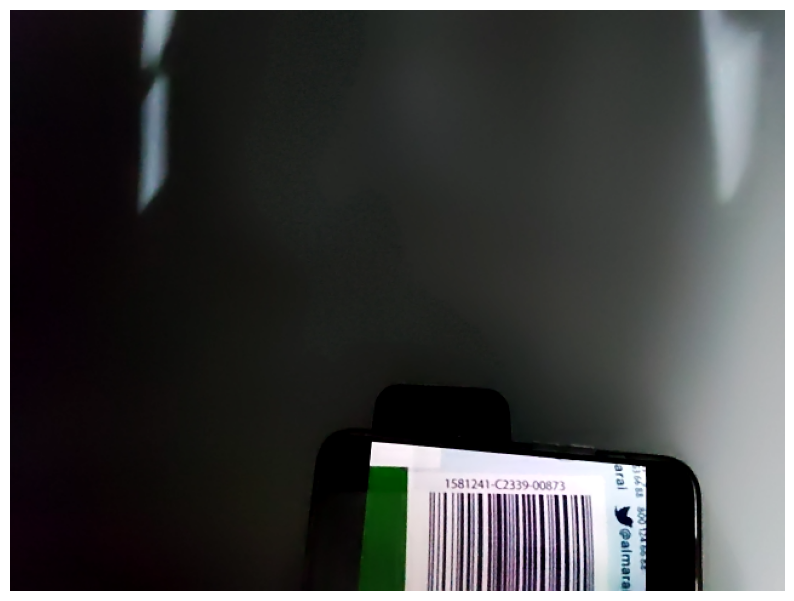

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN13
Data: 6281101220762

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Berain Water
Brand: Unknown
Categories: en:mineral-waters
Ingredients: Not available...
Image URL: https://images.openfoodfacts.org/images/products/628/110/122/0762/front_en.7.400.jpg

 Nutrition Facts (per 100g):
 - Energy: 0 kcal
 - Sugars: 0 g
 - Proteins: 0 g


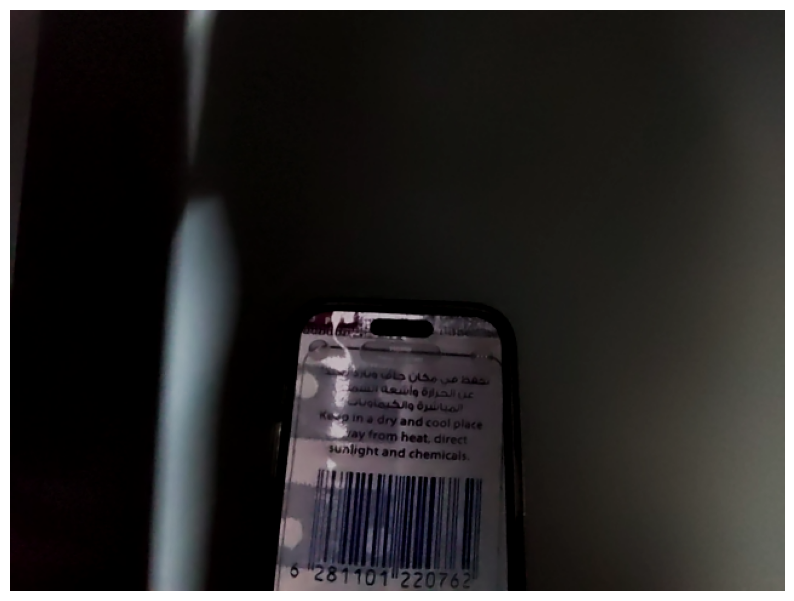

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN13
Data: 5411188140887

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Barista vanillesmaak
Brand: Alpro
Categories: Plantaardige melken
Ingredients: Haver - basis (67,5%) (water, haver (4,7%)), sojabasis (24,4%) (water, gepelde sojabonen (1,7%)), su...
Image URL: https://images.openfoodfacts.org/images/products/541/118/814/0887/front_nl.4.400.jpg

 Nutrition Facts (per 100g):
 - Energy: 46 kcal
 - Sugars: 4.5 g
 - Proteins: 0.7 g


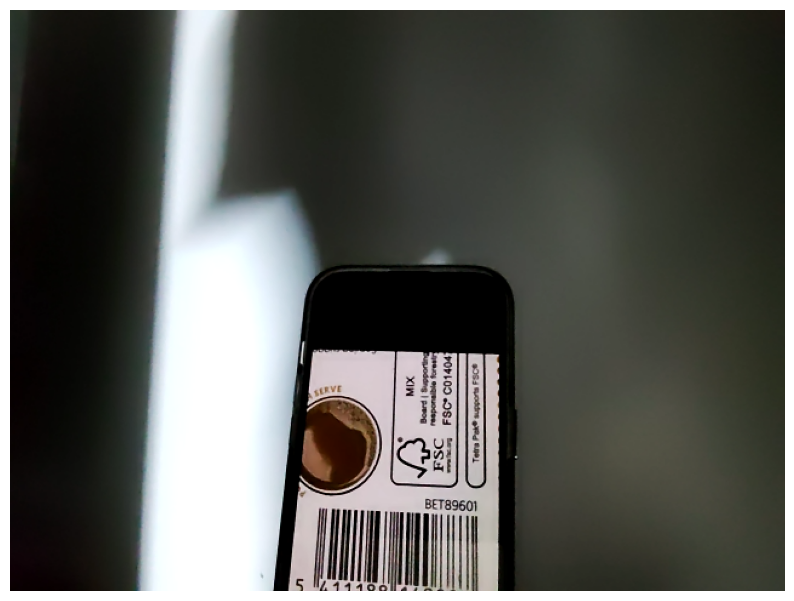

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN13
Data: 3608580103325

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Unknown
Brand: Andros
Categories: Unknown
Ingredients: Not available...
Image URL: https://images.openfoodfacts.org/images/products/360/858/010/3325/front_fr.3.400.jpg


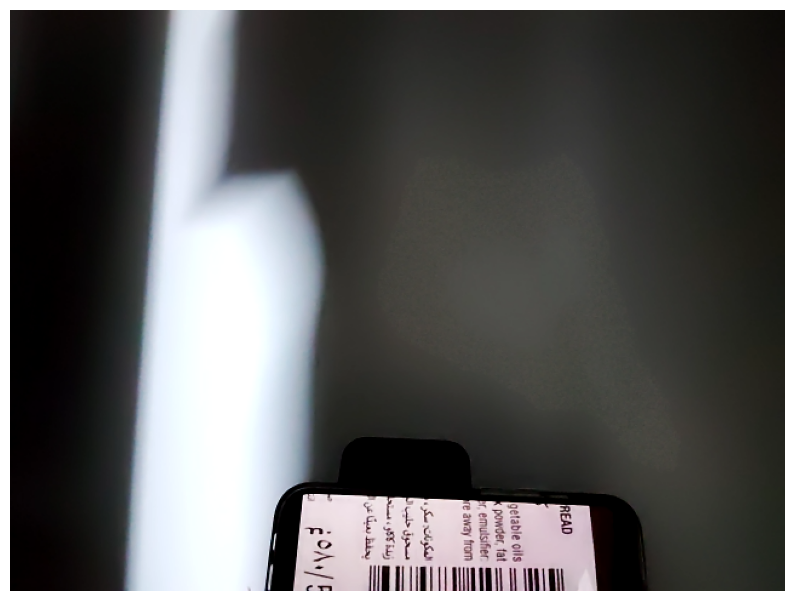

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN13
Data: 3073781190885

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Kiri Fresh Cream & Milk
Brand: Kiri
Categories: en:cheeses
Ingredients: Not available...
Image URL: https://images.openfoodfacts.org/images/products/307/378/119/0885/front_fr.11.400.jpg

 Nutrition Facts (per 100g):
 - Energy: 309 kcal
 - Sugars: 2.5 g
 - Proteins: 9.5 g


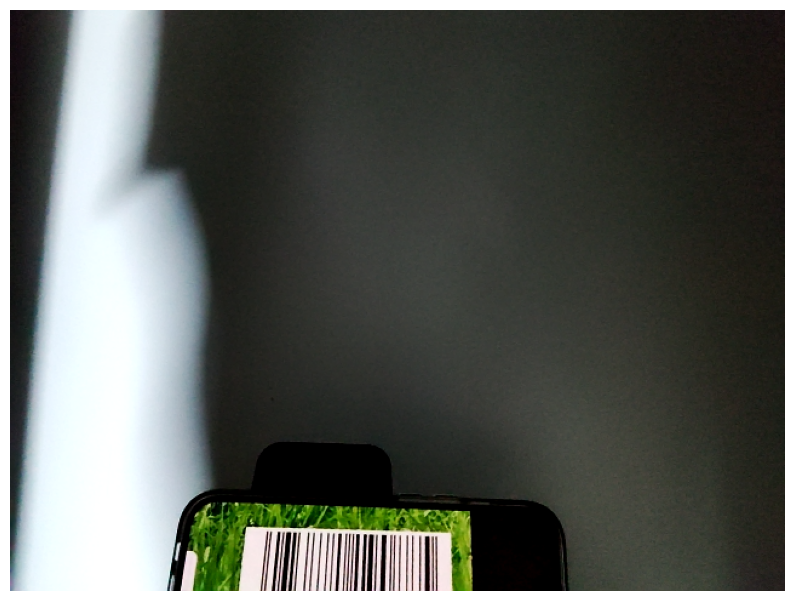

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN8
Data: 80177609

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Kinder Chocolate
Brand: Kinder
Categories: Snacks,Snacks sucrés,Cacao et dérivés,Confiseries,Confiseries chocolatées,Barres,Barres chocolatées,Barres chocolatées au lait
Ingredients: milk  chocolate 40% (sugar, whole  milk  powder, cocoa butter, cocoa mass, emulsifier: lecithins ( s...
Image URL: https://images.openfoodfacts.org/images/products/000/008/017/7609/front_en.345.400.jpg

 Nutrition Facts (per 100g):
 - Energy: N/A kcal
 - Sugars: 53.5 g
 - Proteins: 8.7 g


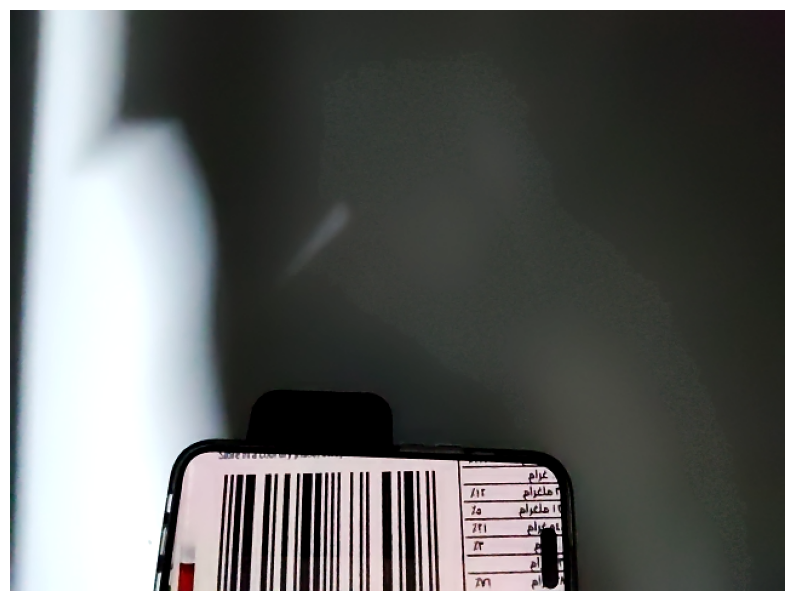

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: EAN13
Data: 8410376023831

 Searching for product info in Open Food Facts...

 Product Information Found:
Name: Digestive zero sin azúcares
Brand: Gullón
Categories: Botanas,Snacks dulces,Galletas y pasteles,Galletas
Ingredients: harina integral de _trigo_ 65,5%, edulcorantes (isomalt, maltitol), aceite vegetal (girasol alto ole...
Image URL: https://images.openfoodfacts.org/images/products/841/037/602/3831/front_en.74.400.jpg

 Nutrition Facts (per 100g):
 - Energy: 430 kcal
 - Sugars: 0.5 g
 - Proteins: 6.2 g


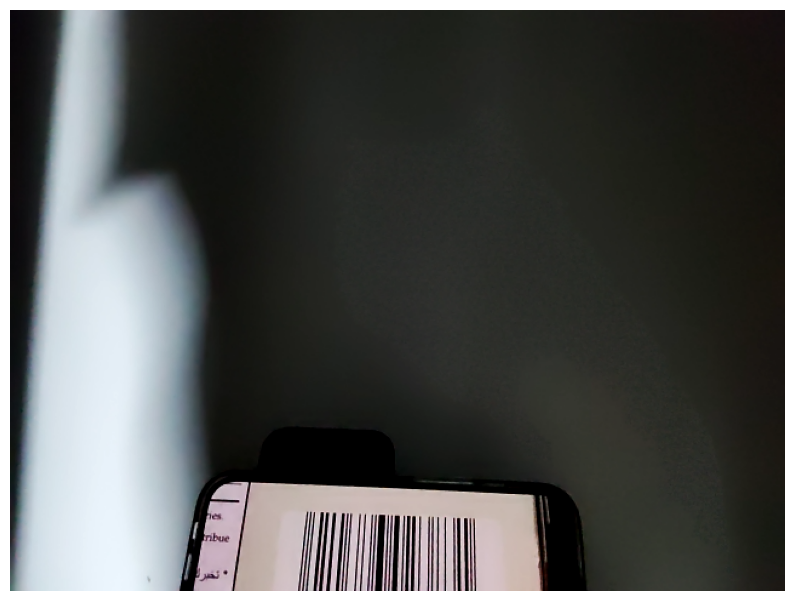

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

 Show your QR code or barcode to the camera...

Code Detected!

Type: QRCODE
Data: http://l.ead.me/barOVP

 QR Code Content:
http://l.ead.me/barOVP


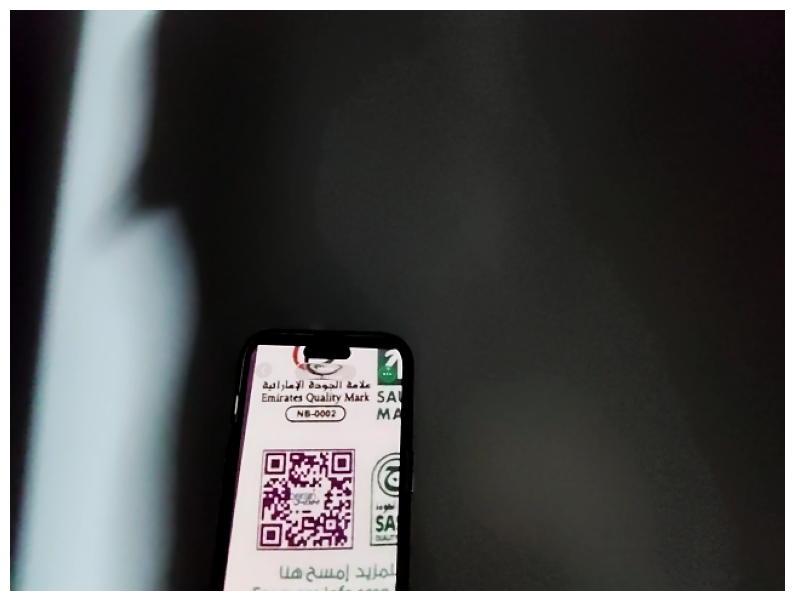

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

Show your QR code or barcode to the camera...
 No QR or Barcode found.


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

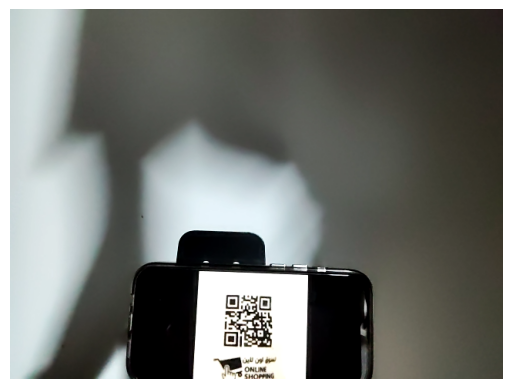

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

Show youre QR code or barcode to the camera...
Code Detected!

Type: QRCODE
Data: http://chaizup.com/

 QR Code Content:
http://chaizup.com/


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

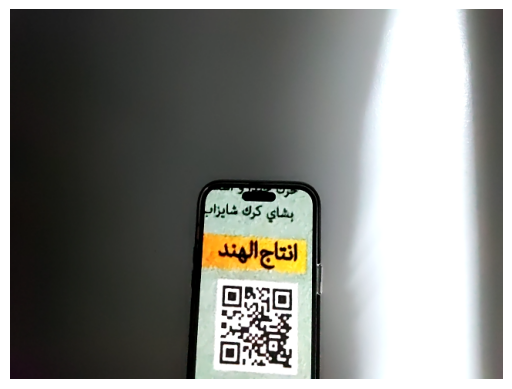

In [ ]:
# ==========================================
# 3. MAIN EXECUTION
# ==========================================

print(" Show your QR code or barcode to the camera...")

# 1. Capture the image
img = take_photo()

# 2. Preprocessing: Convert to Grayscale
# Grayscale reduces computational load and increases contrast for barcode detection
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# 3. Decoding: Detect barcodes or QR codes in the image
decoded_objects = decode(gray)

if decoded_objects:
    print("\nCode Detected!\n")

    for obj in decoded_objects:
        # Extract type (e.g., EAN13, QRCODE) and data
        code_type = obj.type
        code_data = obj.data.decode("utf-8")

        print(f"Type: {code_type}")
        print(f"Data: {code_data}")

        # --- CASE A: QR CODE ---
        if code_type == "QRCODE":
            print("\n QR Code Content:")
            print(code_data)

        # --- CASE B: PRODUCT BARCODE (EAN-13, UPC, etc.) ---
        else:
            print("\n Searching for product info in Open Food Facts...")
            product = get_product_info(code_data)

            if product:
                print("\n Product Information Found:")
                print(f"Name: {product['name']}")
                print(f"Brand: {product['brand']}")
                print(f"Categories: {product['categories']}")
                print(f"Ingredients: {product['ingredients'][:100]}...") # Print first 100 chars
                print("Image URL:", product["image"])

                # Display Nutritional Info
                nutrients = product["nutrients"]
                if nutrients:
                    print("\n Nutrition Facts (per 100g):")
                    # Safely get key nutrients
                    print(f" - Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal")
                    print(f" - Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
                    print(f" - Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            else:
                print(" Product not found in OpenFoodFacts database.")
else:
    print(" No QR or Barcode found in the image.")

# 4. Visualization: Display the captured image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
!pip install pyzbar
!apt-get install -y libzbar0
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pyzbar.pyzbar import decode
import requests

In [ ]:
# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================

def take_photo(filename='photo.jpg', quality=0.8):
  """
  Captures a photo from the user's webcam using JavaScript.
  This is required because Google Colab runs on a remote server
  and cannot access the local webcam directly via Python.
  """
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])

  # Decode the image as a NumPy array for OpenCV
  img = cv2.imdecode(np.frombuffer(binary, np.uint8), -1)
  return img

def get_product_info(barcode_number):
    """
    Queries the Open Food Facts API to retrieve product metadata.
    Args:
        barcode_number (str): The scanned EAN-13 or UPC barcode.
    Returns:
        None (Prints data directly)
    """
    url = f"https://world.openfoodfacts.org/api/v0/product/{barcode_number}.json"

    try:
        response = requests.get(url)
        data = response.json()

        # Check if product exists in the database
        if data.get('status') == 1:
            product = data['product']
            print("\n" + "="*40)
            print(f" PRODUCT DETECTED: {product.get('product_name', 'Unknown Name')}")
            print(f" Brand: {product.get('brands', 'Unknown Brand')}")
            print("-" * 20)

            # Extract Nutritional Info
            nutrients = product.get('nutriments', {})
            print(f" Energy: {nutrients.get('energy-kcal_100g', 'N/A')} kcal/100g")
            print(f" Sugars: {nutrients.get('sugars_100g', 'N/A')} g")
            print(f" Proteins: {nutrients.get('proteins_100g', 'N/A')} g")
            print("="*40 + "\n")
        else:
            print(f"\n Product not found in Open Food Facts database (Code: {barcode_number})")

    except Exception as e:
        print(f"API Connection Error: {e}")

Please click 'Capture' to scan...


<IPython.core.display.Javascript object>

Detected EAN13: 6281101220762

 PRODUCT DETECTED: Berain Water
 Brand: Unknown Brand
--------------------
 Energy: 0 kcal/100g
 Sugars: 0 g
 Proteins: 0 g



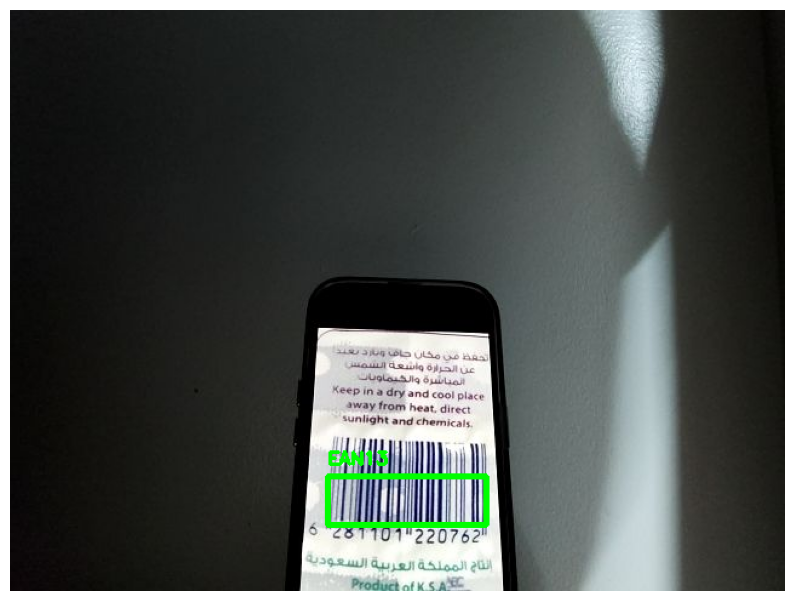

In [ ]:
# ==========================================
# 3. MAIN EXECUTION LOOP
# ==========================================

try:
  # 1. Capture the image
  print("Please click 'Capture' to scan...")
  img = take_photo()

  # 2. Preprocess: Convert to Grayscale for better detection
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # 3. Decode: Find barcodes/QR codes
  detected_codes = decode(gray)

  if not detected_codes:
      print("No Code Detected. Please try again with better lighting.")

  for code in detected_codes:
      # Decode bytes to string
      code_data = code.data.decode('utf-8')
      code_type = code.type

      print(f"Detected {code_type}: {code_data}")

      # 4. Logic: If it is a QR code, show link. If Barcode, fetch Product Data.
      if code_type == 'QRCODE':
          print(f"Link/Data: {code_data}")
      else:
          # Assume it's a product barcode (EAN13, UPC, etc.)
          get_product_info(code_data)

      # Draw a rectangle around the code
      (x, y, w, h) = code.rect
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
      cv2.putText(img, f"{code_type}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  # 5. Show the final result
  plt.figure(figsize=(10,10))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

except Exception as e:
  print(f"An error occurred: {str(e)}")

Please click 'Capture' to scan...


<IPython.core.display.Javascript object>

Detected QRCODE: http://l.ead.me/barOVP
Link/Data: http://l.ead.me/barOVP


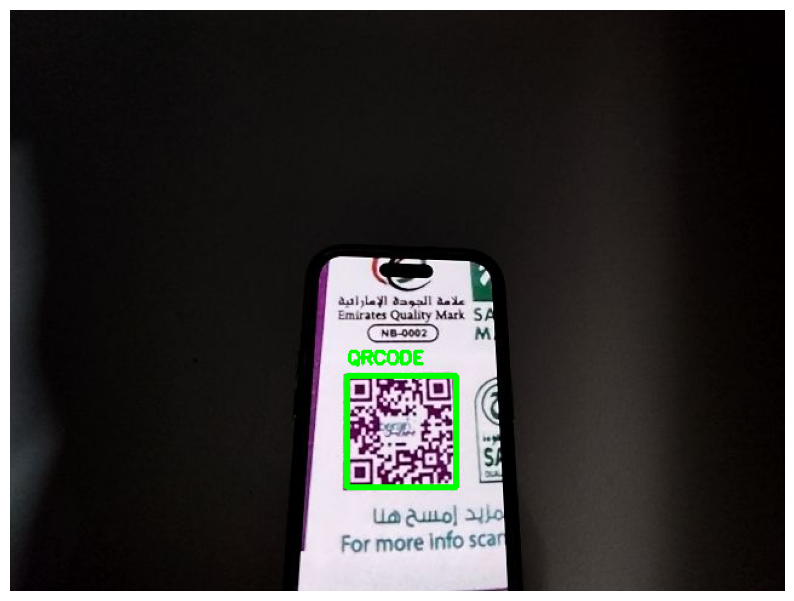

In [ ]:
# ==========================================
# 3. MAIN EXECUTION LOOP
# ==========================================

try:
  # 1. Capture the image
  print("Please click 'Capture' to scan...")
  img = take_photo()

  # 2. Preprocess: Convert to Grayscale for better detection
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # 3. Decode: Find barcodes/QR codes
  detected_codes = decode(gray)

  if not detected_codes:
      print("No Code Detected. Please try again with better lighting.")

  for code in detected_codes:
      # Decode bytes to string
      code_data = code.data.decode('utf-8')
      code_type = code.type

      print(f"Detected {code_type}: {code_data}")

      # 4. Logic: If it is a QR code, show link. If Barcode, fetch Product Data.
      if code_type == 'QRCODE':
          print(f"Link/Data: {code_data}")
      else:
          # Assume it's a product barcode (EAN13, UPC, etc.)
          get_product_info(code_data)

      # Draw a rectangle around the code
      (x, y, w, h) = code.rect
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
      cv2.putText(img, f"{code_type}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  # 5. Show the final result
  plt.figure(figsize=(10,10))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

except Exception as e:
  print(f"An error occurred: {str(e)}")

Please click 'Capture' to scan...


<IPython.core.display.Javascript object>

Detected EAN13: 5411188140887

 PRODUCT DETECTED: Barista vanillesmaak
 Brand: Alpro
--------------------
 Energy: 46 kcal/100g
 Sugars: 4.5 g
 Proteins: 0.7 g



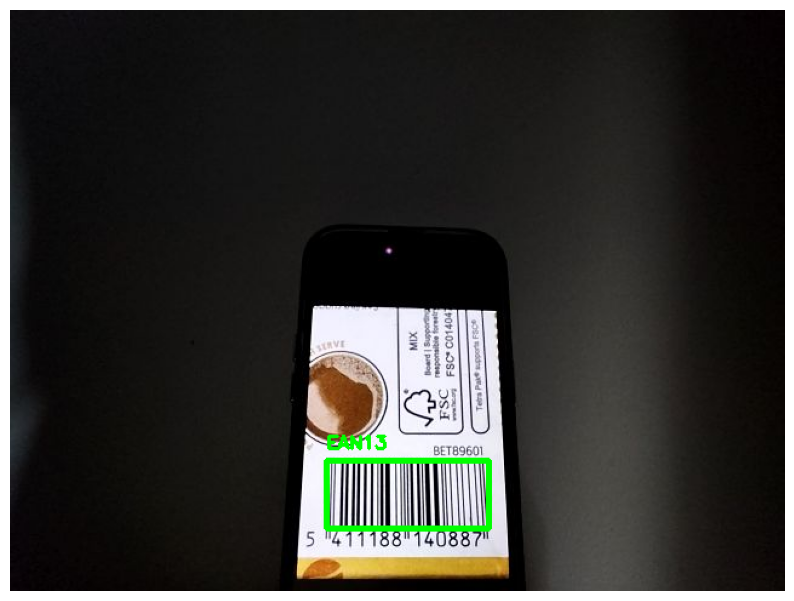

In [ ]:
# ==========================================
# 3. MAIN EXECUTION LOOP
# ==========================================

try:
  # 1. Capture the image
  print("Please click 'Capture' to scan...")
  img = take_photo()

  # 2. Preprocess: Convert to Grayscale for better detection
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # 3. Decode: Find barcodes/QR codes
  detected_codes = decode(gray)

  if not detected_codes:
      print("No Code Detected. Please try again with better lighting.")

  for code in detected_codes:
      # Decode bytes to string
      code_data = code.data.decode('utf-8')
      code_type = code.type

      print(f"Detected {code_type}: {code_data}")

      # 4. Logic: If it is a QR code, show link. If Barcode, fetch Product Data.
      if code_type == 'QRCODE':
          print(f"Link/Data: {code_data}")
      else:
          # Assume it's a product barcode (EAN13, UPC, etc.)
          get_product_info(code_data)

      # Draw a rectangle around the code
      (x, y, w, h) = code.rect
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
      cv2.putText(img, f"{code_type}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  # 5. Show the final result
  plt.figure(figsize=(10,10))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

except Exception as e:
  print(f"An error occurred: {str(e)}")

Please click 'Capture' to scan...


<IPython.core.display.Javascript object>

Detected QRCODE: http://chaizup.com/
Link/Data: http://chaizup.com/


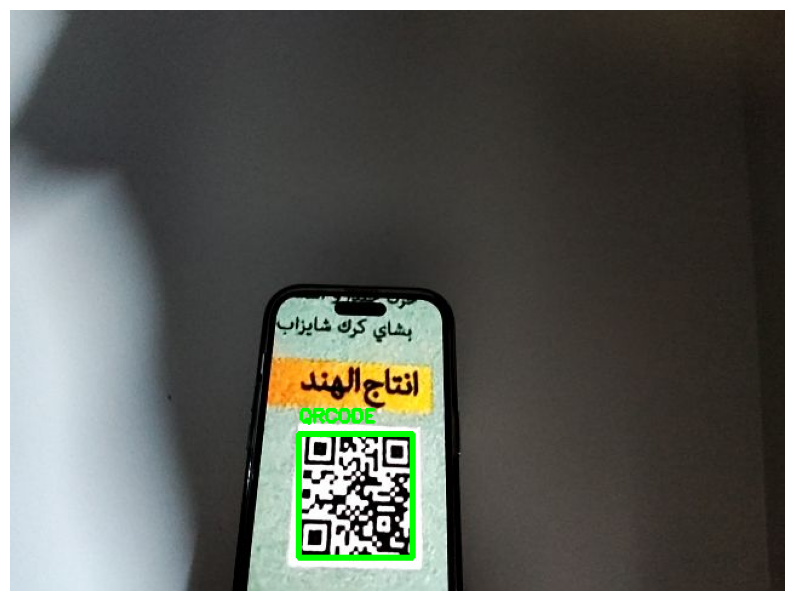

In [ ]:
# ==========================================
# 3. MAIN EXECUTION LOOP
# ==========================================

try:
  # 1. Capture the image
  print("Please click 'Capture' to scan...")
  img = take_photo()

  # 2. Preprocess: Convert to Grayscale for better detection
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

  # 3. Decode: Find barcodes/QR codes
  detected_codes = decode(gray)

  if not detected_codes:
      print("No Code Detected. Please try again with better lighting.")

  for code in detected_codes:
      # Decode bytes to string
      code_data = code.data.decode('utf-8')
      code_type = code.type

      print(f"Detected {code_type}: {code_data}")

      # 4. Logic: If it is a QR code, show link. If Barcode, fetch Product Data.
      if code_type == 'QRCODE':
          print(f"Link/Data: {code_data}")
      else:
          # Assume it's a product barcode (EAN13, UPC, etc.)
          get_product_info(code_data)

      # Draw a rectangle around the code
      (x, y, w, h) = code.rect
      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
      cv2.putText(img, f"{code_type}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

  # 5. Show the final result
  plt.figure(figsize=(10,10))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

except Exception as e:
  print(f"An error occurred: {str(e)}")

Code Explanation

The code consists of four main functional blocks designed to capture an image, detect a barcode or QR code, and retrieve information associated with it.
1. Environment Setup & Dependencies
 * Installation: The code begins by installing pyzbar, a Python library used for reading barcodes and QR codes, and libzbar0, the underlying system library required for it to work.
2. Imports and Camera Configuration
 * Libraries: It imports essential libraries such as cv2 (OpenCV) for image processing, numpy for handling image arrays, requests for making API calls to the internet, and matplotlib for displaying the final image.
 * take_photo() Function: Since this is running in a notebook environment (like Google Colab), direct access to the webcam is handled via JavaScript. This function runs a script to open the camera stream, capture a frame, and convert the image data into a format Python can use (a NumPy array).
3. Product Data Retrieval (The "Database" Logic)
 * get_product_info(barcode_number): This function acts as the interface to the data source.
   * It constructs a URL using the scanned barcode number to query the Open Food Facts API.
   * It sends a web request and parses the JSON response. If the product is found (status == 1), it extracts specific details: Product Name, Brand, Categories, Image URL, Ingredients, and Nutrients.
4. Main Execution Flow
 * Capture: It calls take_photo() to get a live image from the user.
 * Processing: The image is converted to grayscale (cv2.COLOR_RGB2GRAY) to make barcode detection more accurate and faster.
 * Decoding: The decode() function scans the image for any barcodes or QR codes.
 * Logic:
   * If a code is found, it checks the type.
   * QR Codes: It simply prints the raw content (e.g., a website link).
   * Barcodes: It uses the barcode number to call get_product_info and prints the nutritional data and product details fetched from the internet.
 * Visualization: Finally, it displays the captured image with the detected code.